# Preprocessing
### We want to read in this .h5 file and put out data into chunks

#### Things we want to control
- Chunk size
- Time subsampling
- Spatial subsampling

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

### PreProcess

In [1]:
import preprocess2
import importlib

importlib.reload(preprocess2)
from preprocess2 import ProcessingConfig, HDF5Processor
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer

config = ProcessingConfig(
        test_split=.2,
        chunk_size=100,
        subsample_rate=2,
        start_idx=1000,    # Start from the 1000th timestep
        end_idx=5000,       # End at the 5000th timestep
        normalizer = UnitGaussianNormalizer(dim=[0,2,3]),
        normalizer_size = 100
    )
    
processor = HDF5Processor("/Users/anthonypoole/Repositories/hw_snapshots.h5")
metadata = processor.process_file(
    train_output_file="train_processed.h5",
    test_output_file="test_processed.h5",
    config=config
)
print(f"Processed file metadata: {metadata}")

TypeError: ProcessingConfig.__init__() got an unexpected keyword argument 'normalizer'

### Create Dataloaders

In [2]:
from data_utils import CustomDataset, create_dataloaders

# Create dataloader
train_loader, test_loader = create_dataloaders(
    train_file="train_processed.h5",
    test_file="test_processed.h5",
    batch_size=2,
    input_size=20,
    drop_last=True,
)

# Example iteration
for batch in test_loader:
    x = batch['x']  # Shape: (batch_size, channels, x_dim, y_dim, input_size)
    y = batch['y']  # Shape: (batch_size, channels, x_dim, y_dim, chunk_size - input_size)
    der_x = batch['der_x']  # Dict of tensors, each shape: (batch_size, input_size, n_invariants)
    der_y = batch['der_y']  # Dict of tensors, each shape: (batch_size, chunk_size - input_size, n_invariants)
    
    print(x.shape)
    print(y.shape)
    print(der_x.shape)
    print(der_y.shape)
    break

torch.Size([2, 3, 512, 512, 20])
torch.Size([2, 3, 512, 512, 80])
torch.Size([2, 7, 20])
torch.Size([2, 7, 80])


### Normalize

In [1]:
import importlib
import neuralop

importlib.reload(neuralop)
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
from neuralop.data.datasets import load_darcy_flow_small

device = "cpu"

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

pp
pp2
pp3
pp4 False
torch.Size([1000, 1, 16, 16])
pp5 True
torch.Size([1000, 1, 16, 16])
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


/Users/anthonypoole/Repositories/Hasegawa-Wakatani-Prediction/neuraloperator/neuralop/data/datasets/pt_dataset.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = to

### Test out some downsampling techniques

(256, 256)


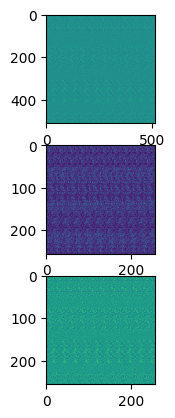

In [60]:
import numpy as np
from scipy import signal
from scipy.ndimage import zoom
import pywt

def average_pooling(data, factor):
    """Downsample using average pooling"""
    h, w = data.shape
    return data.reshape(h//factor, factor, w//factor, factor).mean(axis=(1,3))

def fourier_downsample(data, target_size):
    """Downsample in Fourier space to preserve frequency information"""
    # Compute 2D FFT
    f_transform = np.fft.fft2(data)
    f_shift = np.fft.fftshift(f_transform)
    
    # Calculate center and target size
    center_y, center_x = [dim//2 for dim in f_shift.shape]
    target_y, target_x = target_size
    half_y, half_x = target_y//2, target_x//2
    
    # Crop frequency spectrum
    f_crop = f_shift[center_y-half_y:center_y+half_y, 
                     center_x-half_x:center_x+half_x]
    
    # Inverse FFT
    i_shift = np.fft.ifftshift(f_crop)
    downsampled = np.fft.ifft2(i_shift)
    
    return np.abs(downsampled)

og = data_chunks[0,0,:,:,0] 
f = fourier_downsample(og, (256,256))
m = average_pooling(og, 2)
print(f.shape)
plt.subplot(3,1,1)
plt.imshow(og)
plt.subplot(3,1,2)
plt.imshow(f)
plt.subplot(3,1,3)
plt.imshow(m)

In [2]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def sliding_window(arr, window_size):
    stride_0, stride_1, stride_2, stride_3 = arr.strides
    return as_strided(arr, shape=(arr.shape[0] // window_size, window_size, *arr.shape[1:]),
                      strides=(stride_0 * window_size, stride_0, stride_1, stride_2, stride_3))

# Example array
x, y, z = 1000, 512, 512
data = np.random.rand(x, 3, y, z)

# Define window (chunk) size
chunk_size = 100

# Get chunks without explicit looping
chunks = sliding_window(data, chunk_size)

# Now apply a function to all chunks at once using a vectorized operation
result = np.sum(chunks, axis=2)  # Sum across each chunk
print(result.shape)  # This will have shape (10, 3, 512, 512)


(10, 100, 512, 512)
